# O-mode Reflectometry simulator

Getting a simulated profile, extract the simulated signal from said profile and reconstruct the profile.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simps
import sys
sys.path.append('../')
sys.path.append('../reflib/')
from reflib import *
from scipy import signal

## Simulating a typical AUG H-mode density profile

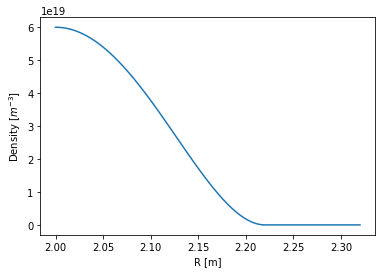

In [3]:
R0 = 2.22
Rant = 2.32
radius, dens = SimulDensPerf(Rmid = 2.0, R0=R0, Rant=Rant, m=2, n=2)
plt.xlabel('R [m]')
plt.ylabel('Density [$m^{-3}$]')
plt.plot(radius, dens)

## Declaring a frequency sweep

In [4]:
fstart = 16e9
fstop = 50e9

In [5]:
dstart = f2n(fstart)
dstop = f2n(fstop)

In [6]:
perfmask = (dens >= dstart) & (dens <= dstop)

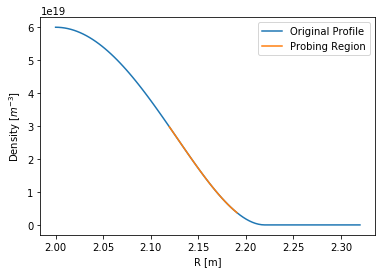

In [7]:
plt.plot(radius, dens, label='Original Profile')
plt.plot(radius[perfmask], dens[perfmask], label='Probing Region')
#plt.xlim(2.15, 2.25)
plt.xlabel('R [m]')
plt.ylabel('Density [$m^{-3}$]')
plt.legend()
plt.show()

In [8]:
fpts = 1024
fprobe = np.linspace(fstart, fstop, fpts, endpoint=True)

### Refractive index

/home/guimas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


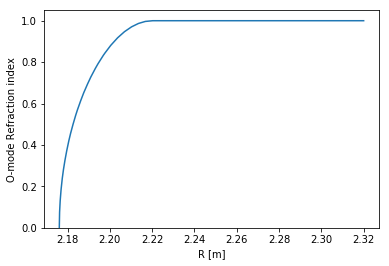

In [13]:
interpts = 1024
interp_perf = interp1d(radius, dens)
interp_rad = interp1d(dens, radius)
total_phase = []

fp = 25e9
dens_probe = f2n(fp)

r_int = np.linspace(interp_rad(dens_probe), Rant, interpts, endpoint=True)
n_int = interp_perf(r_int)

#plt.plot(radius, dens, lw=3)
#plt.plot(r_int, n_int, lw=3)
#plt.xlim(2.15, 2.25)
NO = np.sqrt(1-n_int/dens_probe)
NO[0] = 0.0

plt.ylabel('O-mode Refraction index')
plt.xlabel('R [m]')
plt.plot(r_int, NO)
plt.ylim(bottom=0)
plt.show()

In [11]:
NO[1]

0.075408707252030166

### Total phase shift

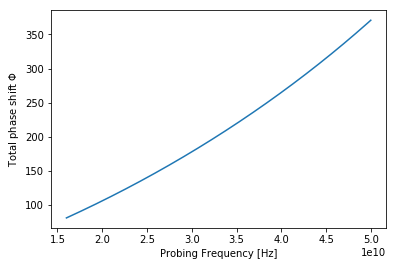

In [11]:
total_phase = []
#Avoid numerical errors due to the sqrt
epsi = 1e-15

#Do a numeric aproach 
for f in fprobe:
    dens_probe = f2n(f)
    r_int = np.linspace(interp_rad(dens_probe)+epsi, Rant, interpts, endpoint=True)
    n_int = interp_perf(r_int)
    #Refractive index
    NO = np.sqrt(1-n_int/dens_probe)
        
    #Refractive index
    total_phase.append( 4.0*np.pi*f/3e8*simps(NO, x=r_int) )
    
    
#Not interested in the error, hence the [0]
total_phase = np.array(total_phase)

plt.plot(fprobe, total_phase)
plt.xlabel('Probing Frequency [Hz]')
plt.ylabel('Total phase shift $\Phi$')
plt.show()

### Simulated signal

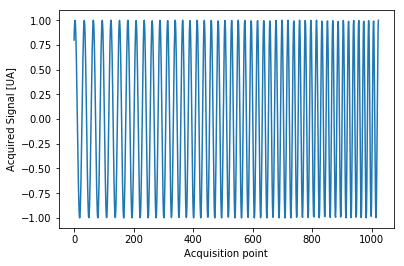

In [12]:
sig = np.cos(total_phase)
plt.xlabel('Acquisition point')
plt.ylabel('Acquired Signal [UA]')
plt.plot(sig)
plt.show()

### Spectral analysis

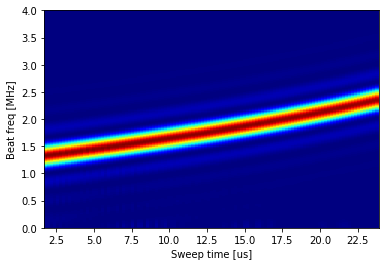

In [23]:
fsamp = 40e6
f, t, Sxx = signal.spectrogram(sig, fsamp*1e-6, nfft=2048, nperseg=136, noverlap=128)#, nperseg=32, noverlap=16)

plt.pcolormesh(t, f, Sxx, cmap='jet')
plt.ylim(0, 4.0)
plt.xlabel('Sweep time [us]')
plt.ylabel('Beat freq [MHz]')
plt.show()

### Extracting the beat frequency

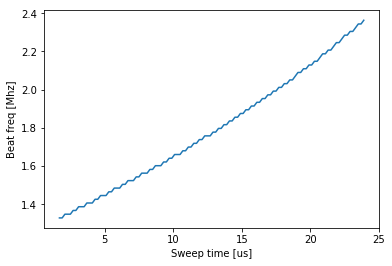

In [14]:
beat_f = f[np.argmax(Sxx, axis=0)]

plt.plot(t, beat_f)
#plt.ylim(0, 2.)
plt.xlabel('Sweep time [us]')
plt.ylabel('Beat freq [Mhz]')
plt.show()

In [15]:
Swp_rate = (fstop-fstart) / (1024.0/fsamp)
print Swp_rate

1.328125e+15


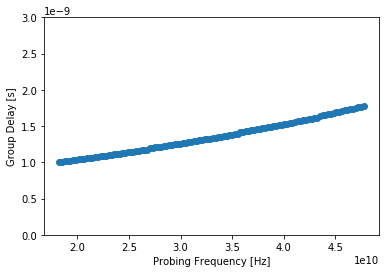

In [20]:
tau_g = beat_f*1e6 / Swp_rate
f_probsw = t*1e-6/(1024.0/fsamp)*(fstop-fstart) + fstart

plt.scatter(f_probsw, tau_g)
plt.ylim(0, 3e-9)
plt.xlabel('Probing Frequency [Hz]')
plt.ylabel('Group Delay [s]')
plt.show()

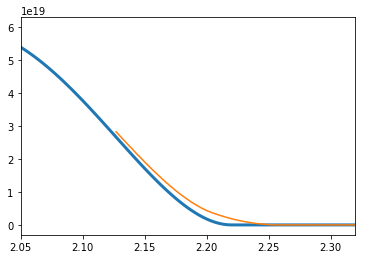

In [18]:
Rinit = 2.26

r, n, fpro, gdel = CalcInvPerfO(f_probsw, tau_g, vacd=Rant-Rinit)
plt.plot(radius, dens, lw=3)
plt.plot(Rant - r, n)
plt.xlim(2.05, 2.32)
plt.show()

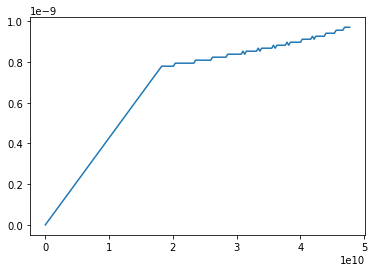

In [48]:
init_pts = 32
temp = np.linspace(0.0, f_probsw[0], init_pts)
f_init = np.concatenate((temp, f_probsw))
temp = np.linspace(0.0, tau_g[0], init_pts)
tau_init = np.concatenate((temp, tau_g))
plt.plot(f_init, tau_init)
plt.show()